In [2]:
gpucb_1 = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_maze_fixed_MainProcess_pid715507_20251105_221317/updates.csv')
gpucb_2 = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_maze_fixed_MainProcess_pid715607_20251105_221323/updates.csv')
gpucb_3 = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_maze_fixed_MainProcess_pid715693_20251105_221328/updates.csv')
ppo_baseline1 = Path('/home/ubuntu/RL-Workflow-Search/logs/ppo_baseline_maze_mp_20251106_190240/updates.csv')
ppo_baseline2 = Path('/home/ubuntu/RL-Workflow-Search/logs/ppo_baseline_maze_mp_20251106_190243/updates.csv')
ppo_baseline3 = Path('/home/ubuntu/RL-Workflow-Search/logs/ppo_baseline_maze_mp_20251106_190245/updates.csv')
hrl_baseline1 = Path('/home/ubuntu/RL-Workflow-Search/logs/hrl_baseline_maze_runs_20251106_194326/updates.csv')
hrl_baseline2 = Path('/home/ubuntu/RL-Workflow-Search/logs/hrl_baseline_maze_runs_20251106_194329/updates.csv')
hrl_baseline3 = Path('/home/ubuntu/RL-Workflow-Search/logs/hrl_baseline_maze_runs_20251106_194331/updates.csv')
sac_baseline1 = Path('/home/ubuntu/RL-Workflow-Search/logs/sac_maze_fixed_MainProcess_pid716037_20251105_221350/updates.csv')
sac_baseline2 = Path('/home/ubuntu/RL-Workflow-Search/logs/sac_maze_fixed_MainProcess_pid716123_20251105_221356/updates.csv')
sac_baseline3 = Path('/home/ubuntu/RL-Workflow-Search/logs/sac_maze_fixed_MainProcess_pid716209_20251105_221401/updates.csv')


Loaded GP-UCB run 1: 9999 updates
Loaded GP-UCB run 2: 9999 updates
Loaded GP-UCB run 3: 9999 updates


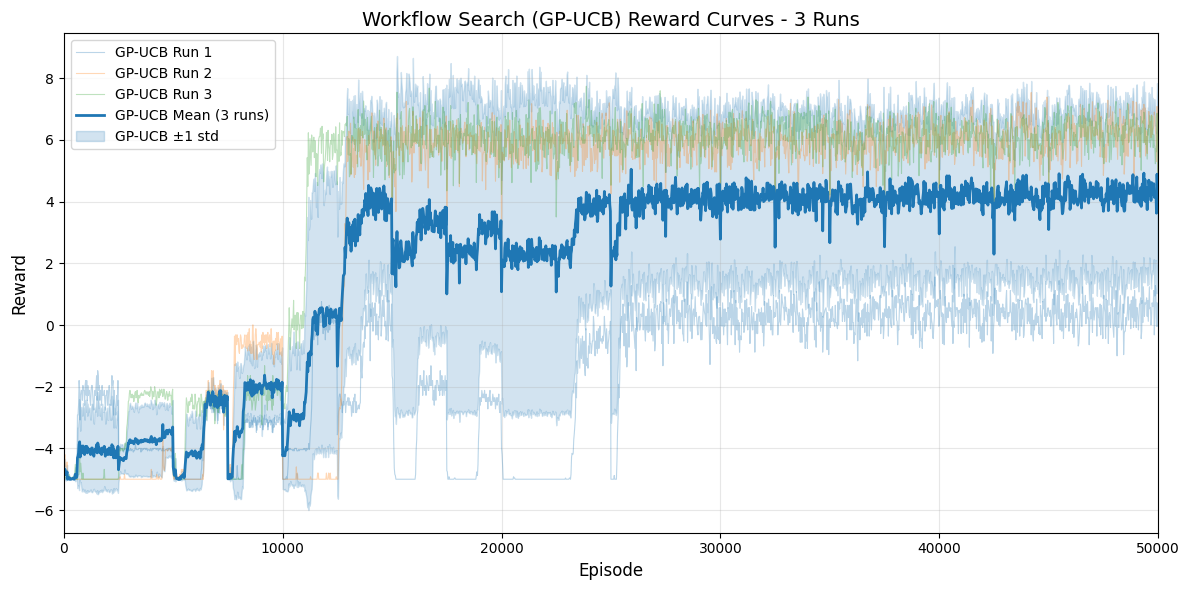


Plotted 3 GP-UCB runs up to 50000 episodes


In [3]:
# Plot Workflow Search (GP-UCB) Reward Curves - 3 Runs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load all 3 GP-UCB runs
gpucb_paths = [gpucb_1, gpucb_2, gpucb_3]
gpucb_dfs = []

for i, path in enumerate(gpucb_paths):
    if path.exists():
        df = pd.read_csv(path)
        # Normalize column names
        if 'mean_env_return' not in df.columns:
            if 'mean_env_ep_return' in df.columns:
                df = df.rename(columns={'mean_env_ep_return': 'mean_env_return'})
            elif 'mean_return' in df.columns:
                df = df.rename(columns={'mean_return': 'mean_env_return'})
        
        # Convert to numeric
        df['update'] = pd.to_numeric(df['update'], errors='coerce')
        df['mean_env_return'] = pd.to_numeric(df['mean_env_return'], errors='coerce')
        
        # Create total_update column (cumulative episodes)
        if 'workflow' in df.columns:
            df['total_update'] = np.arange(len(df))
        else:
            df['total_update'] = df['update'] if 'update' in df.columns else np.arange(len(df))
        
        # Convert to episodes (assuming 25 parallel envs per update)
        df['episode'] = df['total_update'] * 25
        
        gpucb_dfs.append(df)
        print(f"Loaded GP-UCB run {i+1}: {len(df)} updates")
    else:
        print(f"Warning: Path {i+1} does not exist: {path}")

# Align all runs to the same episode range
if gpucb_dfs:
    min_episodes = min(len(df) for df in gpucb_dfs) * 25
    max_episodes = min(50000, min_episodes)  # Limit to 50k episodes to match workflow search
    
    # Create episode grid for interpolation
    episode_grid = np.arange(0, max_episodes, 25)  # Every 25 episodes (1 update)
    
    # Interpolate all runs to the same grid
    aligned_rewards = []
    for df in gpucb_dfs:
        df_episodes = df['episode'].values[:len(df)]
        df_rewards = df['mean_env_return'].values[:len(df)]
        
        # Interpolate to common grid
        aligned = np.interp(episode_grid, df_episodes, df_rewards, 
                           left=np.nan, right=np.nan)
        aligned_rewards.append(aligned)
    
    # Compute mean and std across runs
    aligned_rewards = np.array(aligned_rewards)
    mean_rewards = np.nanmean(aligned_rewards, axis=0)
    std_rewards = np.nanstd(aligned_rewards, axis=0)
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot individual runs (light lines)
    for i, df in enumerate(gpucb_dfs):
        plt.plot(df['episode'][:len(df)], df['mean_env_return'][:len(df)], 
                alpha=0.3, linewidth=0.8, color=f'C{i}', 
                label=f'GP-UCB Run {i+1}' if i < 3 else None)
    
    # Plot mean with confidence interval
    valid_mask = ~np.isnan(mean_rewards)
    plt.plot(episode_grid[valid_mask], mean_rewards[valid_mask], 
            linewidth=2, color='C0', label='GP-UCB Mean (3 runs)')
    plt.fill_between(episode_grid[valid_mask], 
                     mean_rewards[valid_mask] - std_rewards[valid_mask],
                     mean_rewards[valid_mask] + std_rewards[valid_mask],
                     alpha=0.2, color='C0', label='GP-UCB ±1 std')
    
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.title('Workflow Search (GP-UCB) Reward Curves - 3 Runs', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_episodes)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPlotted {len(gpucb_dfs)} GP-UCB runs up to {max_episodes} episodes")
else:
    print("No GP-UCB data found to plot")


In [1]:
# Plot PPO Baseline vs GP-UCB Results

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Inline plots
%matplotlib inline

BASELINE_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/ppo_baseline_diagonal_mp_20250828_164323/updates.csv')
BASELINE_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/maze_baseline_1k_20251031_112117/updates.csv')
#BASELINE_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/baseline_regions_20251027_113406/updates.csv')
GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_diagonal_MainProcess_pid3273252_20250902_041740/updates.csv')
GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_diagonal_revisit_MainProcess_pid3176897_20250904_084854/updates.csv')
GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_diagonal_allowrevisit_MainProcess_pid4017383_20250922_002945/updates.csv')
GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/adh_reward_run_MainProcess_pid1250882_20251027_052139/updates.csv')
GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/maze_formal_MainProcess_pid188200_20251031_091451/updates.csv')

#GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/regions_formal_MainProcess_pid1267167_20251027_064738/updates.csv')
assert BASELINE_CSV.exists(), f"Missing baseline CSV: {BASELINE_CSV}"
assert GPUCB_CSV.exists(), f"Missing GP-UCB CSV: {GPUCB_CSV}"

print('Baseline CSV:', BASELINE_CSV)
print('GP-UCB CSV   :', GPUCB_CSV)


Baseline CSV: /home/ubuntu/RL-Workflow-Search/logs/maze_baseline_1k_20251031_112117/updates.csv
GP-UCB CSV   : /home/ubuntu/RL-Workflow-Search/logs/maze_formal_MainProcess_pid188200_20251031_091451/updates.csv


In [2]:
# Load CSVs

def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalize common column names across scripts
    # Baseline expected: update, mean_env_return, mean_adherence, avg_ep_len
    # GP-UCB expected: update, mean_env_return (EvalEnv canonical or rollout env-only), mean_adherence, avg_ep_len
    # Some scripts may save different headers; try to align
    rename_map = {}
    if 'mean_env_ep_return' in df.columns and 'mean_env_return' not in df.columns:
        rename_map['mean_env_ep_return'] = 'mean_env_return'
    if 'mean_return' in df.columns and 'mean_env_return' not in df.columns:
        rename_map['mean_return'] = 'mean_env_return'
    if 'episode_len_mean' in df.columns and 'avg_ep_len' not in df.columns:
        rename_map['episode_len_mean'] = 'avg_ep_len'
    if rename_map:
        df = df.rename(columns=rename_map)

    # Ensure required columns exist (fill with NaNs if missing)
    for col in ['update', 'mean_env_return', 'mean_adherence', 'avg_ep_len']:
        if col not in df.columns:
            df[col] = np.nan

    # Coerce numeric
    for col in ['update', 'mean_env_return', 'mean_adherence', 'avg_ep_len']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

baseline_df = load_csv(BASELINE_CSV)
gpucb_df = load_csv(GPUCB_CSV)

baseline_df.head(), gpucb_df.head()


(   update  mean_env_return  mean_adherence  success_rate  policy_loss  \
 0       0             -4.0            0.25           0.0     0.037911   
 1       1             -5.0            0.00           0.0    -0.065970   
 2       2             -5.0            0.00           0.0    -0.032213   
 3       3             -4.0            0.25           0.0     0.003551   
 4       4             -4.0            0.25           0.0    -0.000864   
 
    value_loss   entropy  avg_ep_len  
 0    0.011495  1.367464         NaN  
 1    0.001331  1.327933         NaN  
 2    0.002000  1.285325         NaN  
 3    0.007449  1.308458         NaN  
 4    0.009419  1.332641         NaN  ,
   workflow  visit  update  total_update  mean_return_shaped  mean_env_return  \
 0  2-0-1-3      1       0             1          -21.039989            -8.00   
 1  2-0-1-3      1       1             2           -6.079990            -7.20   
 2  2-0-1-3      1       2             3            5.000010            -6.4

In [3]:
# Rolling helpers and cumulative update for GP-UCB

def add_rolling(df: pd.DataFrame, col: str, window: int = 25) -> pd.DataFrame:
    out = df.copy()
    if col in out.columns:
        out[f'{col}_roll'] = out[col].rolling(window=window, min_periods=max(3, window//5)).mean()
    return out

# For GP-UCB, convert per-workflow updates to a global cumulative update index
# Expect a 'workflow' column; if missing, infer single-workflow stream
if 'workflow' in gpucb_df.columns:
    # Ensure chronological order: by workflow appearance then within-workflow update
    gpucb_df = gpucb_df.copy()
    gpucb_df['__row_id__'] = np.arange(len(gpucb_df))
    # We assume the CSV is already in time order per training loop append
    gpucb_df['total_update'] = np.arange(len(gpucb_df))
else:
    gpucb_df['total_update'] = gpucb_df['update'] if 'update' in gpucb_df.columns else np.arange(len(gpucb_df))

baseline_df = add_rolling(baseline_df, 'mean_env_return')
baseline_df = add_rolling(baseline_df, 'mean_adherence')
baseline_df = add_rolling(baseline_df, 'avg_ep_len')

gpucb_df = add_rolling(gpucb_df, 'mean_env_return')
gpucb_df = add_rolling(gpucb_df, 'mean_adherence')
gpucb_df = add_rolling(gpucb_df, 'avg_ep_len')

baseline_df.tail(2), gpucb_df.tail(2)


(     update  mean_env_return  mean_adherence  success_rate  policy_loss  \
 998     998             -4.0            0.25           0.0     0.009091   
 999     999             -4.0            0.25           0.0     0.012572   
 
      value_loss   entropy  avg_ep_len  mean_env_return_roll  \
 998    0.010261  0.074126         NaN                 -4.08   
 999    0.010378  0.068674         NaN                 -4.08   
 
      mean_adherence_roll  avg_ep_len_roll  
 998                 0.23              NaN  
 999                 0.23              NaN  ,
     workflow  visit  update  total_update  mean_return_shaped  \
 531  0-1-2-3     30       5           531           98.671046   
 532  0-1-2-3     30       6           532          101.203176   
 
      mean_env_return  mean_adherence mode_seq  mode_frac  avg_ep_len  \
 531         6.745970        0.932836  0 1 2 3   0.850746         NaN   
 532         7.149206        0.956349  0 1 2 3   0.936508         NaN   
 
      __row_id__  m

In [4]:
s = pd.concat([gpucb_df['mean_env_return'].iloc[:1000],
               gpucb_df['mean_env_return'].iloc[4000:7000]])

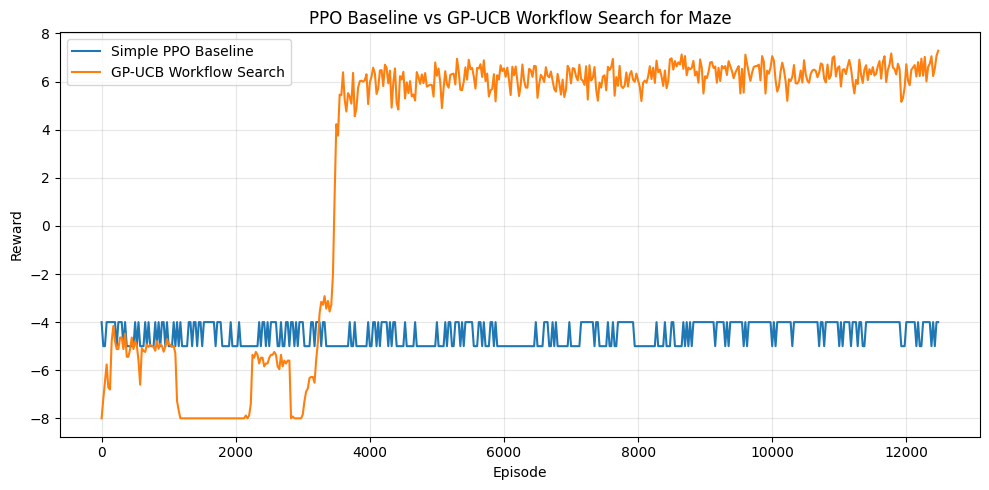

In [7]:
# Plot: Env-only reward vs total updates (baseline update vs GP-UCB total_update)

plt.figure(figsize=(10,5))
plt.plot(baseline_df['update'][:500]*25, baseline_df['mean_env_return'][:500], alpha=1, label='Simple PPO Baseline')
#if 'mean_env_return_roll' in baseline_df.columns:
    #plt.plot(baseline_df['update']*25, baseline_df['mean_env_return_roll'], label='Simple PPO Baseline')

plt.plot(gpucb_df['total_update'][:500]*25, gpucb_df['mean_env_return'][:500], alpha=1, label='GP-UCB Workflow Search')
#if 'mean_env_return_roll' in gpucb_df.columns:
    #plt.plot(gpucb_df['total_update']*25, gpucb_df['mean_env_return_roll'], label='GP-UCB Workflow Search')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO Baseline vs GP-UCB Workflow Search for Maze')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


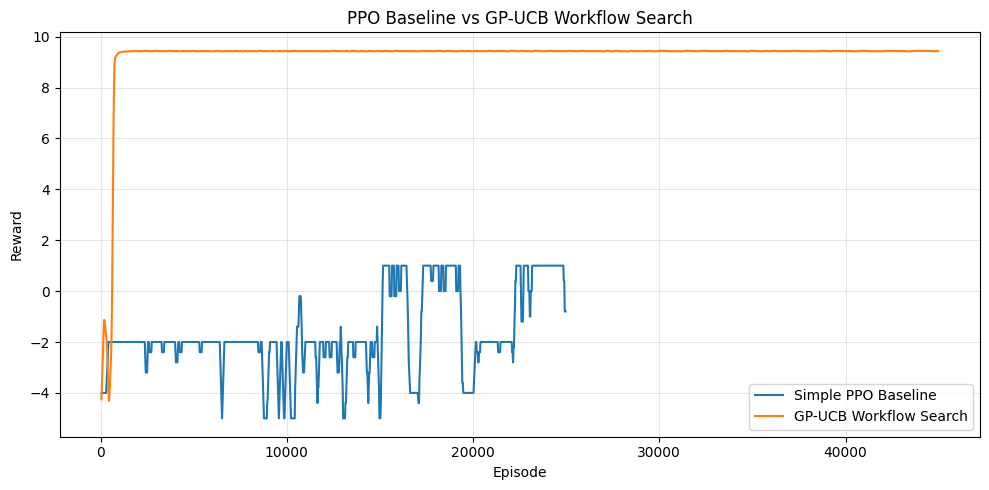

In [14]:
import matplotlib.pyplot as plt

# Set smoothing window (tune as needed, e.g. 10, 20, 50)
smooth_window = 5

plt.figure(figsize=(10, 5))

# Smooth baseline curve
baseline_x = baseline_df['update'][:6000]*25
baseline_y = baseline_df['mean_env_return'][:6000].rolling(smooth_window, min_periods=3).mean()
plt.plot(baseline_x, baseline_y, alpha=1, label='Simple PPO Baseline')

# Smooth GP-UCB curve
gpucb_x = gpucb_df['total_update'][:10000] * 25
gpucb_y = gpucb_df['mean_env_return'][:10000].rolling(smooth_window, min_periods=3).mean()
plt.plot(gpucb_x, gpucb_y, alpha=1, label='GP-UCB Workflow Search')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO Baseline vs GP-UCB Workflow Search')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

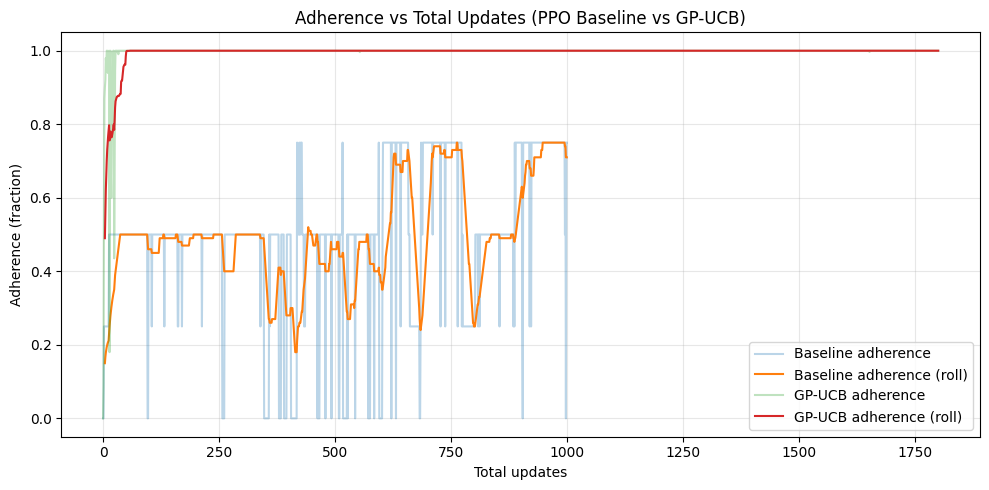

In [15]:
# Plot: Adherence vs total updates

plt.figure(figsize=(10,5))
plt.plot(baseline_df['update'], baseline_df['mean_adherence'], alpha=0.3, label='Baseline adherence')
if 'mean_adherence_roll' in baseline_df.columns:
    plt.plot(baseline_df['update'], baseline_df['mean_adherence_roll'], label='Baseline adherence (roll)')

plt.plot(gpucb_df['total_update'], gpucb_df['mean_adherence'], alpha=0.3, label='GP-UCB adherence')
if 'mean_adherence_roll' in gpucb_df.columns:
    plt.plot(gpucb_df['total_update'], gpucb_df['mean_adherence_roll'], label='GP-UCB adherence (roll)')

plt.xlabel('Total updates')
plt.ylabel('Adherence (fraction)')
plt.title('Adherence vs Total Updates (PPO Baseline vs GP-UCB)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipykernel_111422/4013428692.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(workflows))


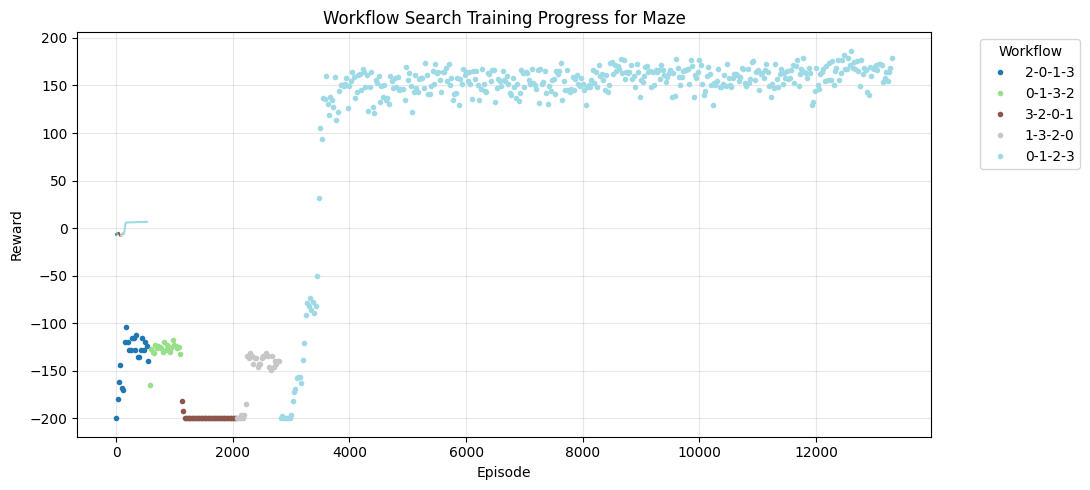

In [9]:
# Plot: GP-UCB env-only return vs total_update, colored by workflow

if 'workflow' not in gpucb_df.columns:
    print('No workflow column found in GP-UCB CSV; cannot color by workflow.')
else:
    # Build a color map per workflow string
    workflows = gpucb_df['workflow'].astype(str).unique()
    cmap = plt.cm.get_cmap('tab20', len(workflows))
    wf_to_color = {wf: cmap(i) for i, wf in enumerate(workflows)}

    plt.figure(figsize=(11,5))
    for wf in workflows:
        sub = gpucb_df[gpucb_df['workflow'].astype(str) == wf]
        plt.plot(sub['total_update'][:1000]*25, sub['mean_env_return'][:1000]*25, '.', color=wf_to_color[wf], alpha=1, label=wf)
        # Optional: a light rolling line per workflow
        if 'mean_env_return_roll' in sub.columns:
            plt.plot(sub['total_update'][:1000], sub['mean_env_return_roll'][:1000], color=wf_to_color[wf], alpha=1)

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Workflow Search Training Progress for Maze')
    plt.legend(title='Workflow', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [17]:
## GP-UCB (revisit) vs Baseline

Using GP-UCB run:
`/home/ubuntu/RL-Workflow-Search/logs/gpucb_diagonal_revisit_MainProcess_pid2579176_20250904_055522/updates.csv`



SyntaxError: invalid syntax (2672524467.py, line 3)

In [ ]:
# GP-UCB (revisit) path
NEW_GPUCB_CSV = Path('/home/ubuntu/RL-Workflow-Search/logs/gpucb_diagonal_revisit_MainProcess_pid2579176_20250904_055522/updates.csv')
assert NEW_GPUCB_CSV.exists(), f"Missing GP-UCB revisit CSV: {NEW_GPUCB_CSV}"
print('GP-UCB revisit CSV:', NEW_GPUCB_CSV)


In [ ]:
# Load GP-UCB (revisit) CSV and add rolling metrics

gpucb_revisit_df = load_csv(NEW_GPUCB_CSV)

# Ensure total_update exists; prefer explicit column if present
if 'total_update' not in gpucb_revisit_df.columns:
    gpucb_revisit_df['total_update'] = (
        gpucb_revisit_df['update'] if 'update' in gpucb_revisit_df.columns else np.arange(len(gpucb_revisit_df))
    )

for col in ['mean_env_return', 'mean_adherence', 'avg_ep_len']:
    if col in gpucb_revisit_df.columns:
        gpucb_revisit_df[f'{col}_roll'] = gpucb_revisit_df[col].rolling(window=25, min_periods=5).mean()

print(gpucb_revisit_df.head(3))
print(gpucb_revisit_df[['update','total_update']].tail(3))


In [ ]:
# Plot: Reward vs Episodes (baseline vs GP-UCB revisit)

plt.figure(figsize=(10,5))
# Episodes assume 25 steps per update, matching earlier cells
plt.plot(baseline_df['update']*25, baseline_df['mean_env_return'], alpha=0.9, label='Baseline')
plt.plot(gpucb_revisit_df['total_update']*25, gpucb_revisit_df['mean_env_return'], alpha=0.9, label='GP-UCB (revisit)')

# Optional rolling overlays if present
if 'mean_env_return_roll' in baseline_df.columns:
    plt.plot(baseline_df['update']*25, baseline_df['mean_env_return_roll'], alpha=1.0, linewidth=2.0, label='Baseline (roll)')
if 'mean_env_return_roll' in gpucb_revisit_df.columns:
    plt.plot(gpucb_revisit_df['total_update']*25, gpucb_revisit_df['mean_env_return_roll'], alpha=1.0, linewidth=2.0, label='GP-UCB (revisit) (roll)')

plt.xlabel('Episode')
plt.ylabel('Reward (env-only)')
plt.title('Reward vs Episodes: Baseline vs GP-UCB (revisit)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Plot: Adherence vs Total Updates (baseline vs GP-UCB revisit)

plt.figure(figsize=(10,5))
plt.plot(baseline_df['update'], baseline_df['mean_adherence'], alpha=0.3, label='Baseline')
if 'mean_adherence_roll' in baseline_df.columns:
    plt.plot(baseline_df['update'], baseline_df['mean_adherence_roll'], alpha=1.0, linewidth=2.0, label='Baseline (roll)')

plt.plot(gpucb_revisit_df['total_update'], gpucb_revisit_df['mean_adherence'], alpha=0.3, label='GP-UCB (revisit)')
if 'mean_adherence_roll' in gpucb_revisit_df.columns:
    plt.plot(gpucb_revisit_df['total_update'], gpucb_revisit_df['mean_adherence_roll'], alpha=1.0, linewidth=2.0, label='GP-UCB (revisit) (roll)')

plt.xlabel('Total updates')
plt.ylabel('Adherence (fraction)')
plt.title('Adherence vs Total Updates: Baseline vs GP-UCB (revisit)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
